## FOOOF on RCS streaming sessions
Inputs

power spectra outputted from MATLAB per RCS streaming channel

* (leveraging the 'Analysis-rcs-data' toolbox (Sellers et al., 2021 *Front. Hum. Neurosci.*)
* prioritzing a similar onboard RCS power calculation

Goals

Use Fitting Oscillations One and Over F (FOOOF) algorithm to identify band peaks and aperiodic contributions in order to:
* remove aperiodic contributions of 
* see stability of band peak frequency over first month of Stage 1
* leverage aperiodic offset and exponent as plausible representations of the lead settling over the first month
    * before stim is turned on so stim-related transient/lasting spectra effects are NOT confounding (besides lasting stage 0 changes)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
import sys
import mat73
import os
from fooof import FOOOFGroup
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

from fooof.plts.annotate import plot_annotated_model
from scipy import stats
import shutil

In [2]:
from IPython.display import Image

In [10]:
rcs_dir    = '/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/'
rcs_subdir = '/stage1_only (pp work up)/'

proc_dir     = '/Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/'
proc_subdir  = 'fooofed'

sense_dict   = pd.read_excel(rcs_dir + 'rcs_sensing_channels_per_hemisphere.xlsx')

In [11]:
sense_dict

,RCS02R,RCS04R,RCS04L,RCS05R,RCS05L,RCS06R,RCS06L,RCS07R,RCS07L
0,RThal +10-8,RACC +3-0,LACC +3-0,RIFG +10-8,LACC +11-8,RSFG +10-8,LCaud +10-8,RSGC +10-8,LSGC +10-8
1,none,RACC +3-1,LACC +3-1,RIFG +11-9,LACC +11-9,RSFG +11-9,LCaud +11-9,RSGC +11-9,LSGC +11-9


* RBL inputs into general FOOOF approach below:

In [12]:
freq_range          = [2, 40]
err_thresh          = 0.1

## FOOOF alogirthim parameters (directly feed into FOOOF object)
peak_width_limits   = [2.0, 5.0]
max_n_peaks         = 4
min_peak_height     = 0.1
peak_threshold      = 2
aperiodic_mode      ='knee'

### Define FOOOF parameters and plotting sub-functions

Since the FOOOFGroup object does not have native plotting/neat exporting

--> implement here per "group" (here defined as the power spectra across session per RCS channel)

In [13]:
def plt_save_aperiodic_overtime(fg_group_results, ch_name, exp_data_dir, aper_long_dir, parsed_db_oi, pt_side, aperiodic_mode):

    tmp_params = pd.DataFrame(fg_group_results)

    aperiodic_offset     = [x[0] for x in tmp_params['aperiodic_params']]

    aperiodic_exponent   = [x[1] for x in tmp_params['aperiodic_params']]
    center_freq          = []
    peak_power           = []
    band_width           = []

    for i_sess in range(tmp_params.shape[0]):
        peak_params = []
        peak_params = tmp_params['peak_params'].iloc[i_sess]


        center_freq.append([x[0] for x in peak_params])
        peak_power.append([x[1] for x in peak_params])
        band_width.append([x[2] for x in peak_params])

    values        = [aperiodic_offset, aperiodic_exponent,
                     center_freq, peak_power, band_width, 
                     tmp_params['r_squared'], tmp_params['error'], tmp_params['gaussian_params']]

    lbls          = ['aperiodic_offset', 'aperiodic_exponent', 
                     'center_freq', 'peak_power', 'band_width',
                    'r_squared', 'error','gaussian_params' ]

    fooof_params = pd.DataFrame(data = values,  index = lbls).transpose()
    
    fooof_params.to_excel(exp_data_dir + ch_name + '_fooof_params.xlsx', index=False)

    ###
    t_exp_corr   = stats.spearmanr(parsed_db_oi['timeStart'], fooof_params['aperiodic_exponent'])
    t_off_corr   = stats.spearmanr(parsed_db_oi['timeStart'], fooof_params['aperiodic_offset'])
    exp_off_corr = stats.spearmanr(fooof_params['aperiodic_exponent'], fooof_params['aperiodic_offset'])

    plt_corrs = [t_exp_corr[0],t_exp_corr[1], t_off_corr[0], t_off_corr[1], exp_off_corr[0], exp_off_corr[1]]


    set_up_str = 'Time, aper_exp         | r = {:.3f} p= {:.3g}\n' + \
                 'Time, aper_offset      | r = {:.3f} p= {:.3g}\n' + \
                 'aper_exp, aper_ offset | r = {:.3f} p= {:.3g}'

    simple_stat_str   =set_up_str.format(*plt_corrs)

    df_vars       = (pt_side, ch_name, parsed_db_oi.shape[0],
                      str(parsed_db_oi['timeStart'].iloc[0])[0:10],   str(parsed_db_oi['timeStart'].iloc[-1])[0:10], 
                     )

    descr_title   = '{} {} | Aperiodic offset and exponent from {} sessions from {} -> {}'.format(*df_vars)

    fig, ax1 = plt.subplots(figsize=(15, 6))
    plt.ylim([-11, 1])
    plt.scatter(parsed_db_oi['timeStart'], 
                fooof_params['aperiodic_offset'],  
                color='blue')

    ax1.set_ylabel("Aperiodic Offset", color='blue', fontsize=14)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx() 
    plt.scatter(parsed_db_oi['timeStart'],
                fooof_params['aperiodic_exponent'],
                color='green',
                )

    plt.title(descr_title, fontsize=18)
    plt.gcf().text(0.5, 0.2,simple_stat_str, fontsize=14)

    ax2.set_ylabel("Aperiodic Exponent", color='green', fontsize=14)
   
    if aperiodic_mode == 'fixed':
        plt.ylim([1, 3])

    plt.savefig(aper_long_dir + ch_name + '_aperiodic_longitudinally.pdf', bbox_inches='tight', dpi = 100)
    plt.close()

### from FOOF analysis plot/save ACROSS sessions:

* aperiodic fit
* relative power spectra (the power spectrum - aperiodic fit)

* fooof parameters
    * aperiodic exponent, and offset
    * periodic center frequecy(ies), power peaks(s), band width(s)
    * model error and r^2
    
* Spearman's correlation of time, aperiodic offset, and exponent



/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07R/stage1_only (pp work up)/RCS07R_
(4, 139, 513)
['RThal +2-0', 'RThal +3-1', 'RSGC +10-8', 'RSGC +11-9']
(513,)


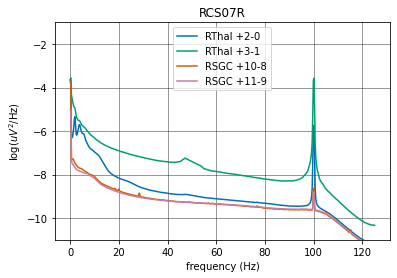

Running FOOOFGroup across 139 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 139 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS07R/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1
/Volumes/DBS Pain 3/rcs_device_data/processed/spectra_per_sess/RCS07L/stage1_only (pp work up)/RCS07L_
(4, 142, 513)
['LGPi +2-0', 'LGPi +3-1', 'LSGC +10-8', 'LSGC +11-9']
(513,)


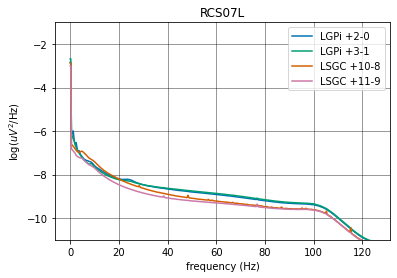

Running FOOOFGroup across 142 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 142 power spectra.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


See:   /Users/Leriche/pia_server/datastore_spirit/human/rcs_chronic_pain/rcs_device_data/ephy_analysis/spectra_per_sess/RCS07L/fooofed (knee)/error_ge_0.1/
for spectra with model error >0.1


In [19]:
pt_sides = ['RCS02R', 'RCS04R', 'RCS04L', 'RCS05R', 'RCS05L', 'RCS06R','RCS06L','RCS07L', 'RCS07R']

#pt_sides = ['RCS07L', 'RCS07R']


pt_sides = ['RCS07R','RCS07L']#,'RCS07L', 'RCS07R']
for i in range(len(pt_sides)):

# check/make directories to organize FOOOF-driven analysis

    #### Carefully import .mat of spectra and meta data
    # inspect mean spectra as sanity check

    raw_dir= rcs_dir +  pt_sides[i] + rcs_subdir +  pt_sides[i] + '_'
    print(raw_dir)

    # To load a .mat 7.3 into Python as a dictionary:
    pwrspectra_by_sess = mat73.loadmat(raw_dir + 'pwrspectra_by_sess.mat')['pwrspectra_by_sess_out']
    print(np.shape(pwrspectra_by_sess))

    ch_names  = mat73.loadmat(raw_dir + 'ch_names.mat')['ch_names_out']
    ch_names  = [i_ch[0] for i_ch in ch_names]
    chs_split = [a_ch.split(' ')[0:2] for a_ch in ch_names]
    ch_names  = [' '.join(a_ch) for a_ch in chs_split]
    print(ch_names)

    fft_bins_inHz = mat73.loadmat(raw_dir + 'fft_bins_inHz.mat')['fft_bins_inHz']
    print(np.shape(fft_bins_inHz))

    parsed_db_oi = pd.read_excel(raw_dir + 'parsed_db_oi.xlsx')

    #### sanity check: importing from MATLAB has all the same spectra and meta data

    plt.style.use('seaborn-colorblind')
    fig = plt.figure()
    fig.patch.set_facecolor('white')    # nescessary so background of figure is white and NOT transparent
    plt.title(pt_sides[i])
    for i_chan in range(len(ch_names)): # loop through channels

        plt.plot(fft_bins_inHz, np.log10(np.mean(pwrspectra_by_sess[i_chan, :, :], 0)))


        plt.ylim([-11,-1])

        plt.xlabel('frequency (Hz)')
        plt.ylabel('log($uV^{2}$/Hz)')

        plt.grid(visible = True, color = 'k', alpha = .5, linestyle = '-')
       # plt.savefig(psd_results + ch_names[i_chan], bbox_inches='tight', dpi = 100)
    plt.legend(ch_names)
    plt.show()

    # * make nested folders for organized outputs

    ### *PREVIOUS RUNS ARE DELETED* FOR TROUBLESHOOTING PURPOSES AND CLARITY

    pt_side_dir   = proc_dir + pt_sides[i] +'/' + proc_subdir + ' (' + aperiodic_mode +')' +'/'


    err_dir        = pt_side_dir + 'error_ge_' + str(err_thresh) + '/'
    aper_dir       = pt_side_dir + 'aperiodic_fits/'
    pwr_specta_dir = pt_side_dir + 'pwr_spectra (aperiodic_fit_removed)/'

    aper_long_dir  = pt_side_dir + 'aperiodic_longitudinal/'

    exp_data_dir   = rcs_dir + pt_sides[i] + rcs_subdir  + 'exported_fooof_data/'

    fooof_dir      = pt_side_dir + 'fooofed_spectra (aperiodic_fit_removed)/'

    raw_exp_dir    = rcs_dir +'raw_spectra/'+pt_sides[i] +'/'

    dirs           = [err_dir, aper_dir, pwr_specta_dir, exp_data_dir, aper_long_dir, fooof_dir, raw_exp_dir]   
   
    ###
    for a_dir in dirs:
        if os.path.exists(a_dir):
            shutil.rmtree(a_dir)

        if not os.path.exists(a_dir):
            os.makedirs(a_dir)

    ###
    if i ==0:
        np.save(raw_exp_dir[0:-7] +'fft_bins_inHz.npy', fft_bins_inHz)
      


    bool_chan = [any(a_ch == sense_dict[pt_sides[i]]) for a_ch in ch_names]
    ind_sense_chan  = [i for i, x in enumerate(bool_chan) if x]
    
    for i_chan in ind_sense_chan:
        spectra_oi = pwrspectra_by_sess[i_chan, :, :]
        
        ## save to xlsx file
        np.save(raw_exp_dir +pt_sides[i]+'_'+ ch_names[i_chan] + '_raw_pwr_spectra.npy', spectra_oi)
        
        # Initialize a FOOOF model object with defined settings
        #fg = FOOOFGroup(peak_width_limits=[2.0, 8.0], max_n_peaks=4, min_peak_height=0.25,
        #       peak_threshold=2, aperiodic_mode='fixed')

        fg = FOOOFGroup(
                        peak_width_limits  = peak_width_limits, 
                        max_n_peaks        = max_n_peaks, 
                        min_peak_height    = min_peak_height,
                        peak_threshold     = peak_threshold,
                        aperiodic_mode     = aperiodic_mode)

        # Model the power spectrum with FOOOF
        fg.fit(fft_bins_inHz, spectra_oi, freq_range)

        # save group report
        fg.save_report(fooof_dir  + ch_names[i_chan] + '_fooof_Group_report.pdf')

        ### Print out results
        #fg.print_results('error')

        ### Find the index of the worst model fit from the group
        #worst_fit_ind = np.argmax(fg.get_params('error'))

        # Extract this model fit from the group
        #fm = fg.get_fooof(worst_fit_ind, regenerate=True)

        # Check results and visualize the extracted model
        ##fm.print_results('error')

        df_vars       = (pt_sides[i], ch_names[i_chan], parsed_db_oi.shape[0],
                          str(parsed_db_oi['timeStart'].iloc[0])[0:10],   str(parsed_db_oi['timeStart'].iloc[-1])[0:10], 
                          freq_range[0], freq_range[1])

        descr_title   = '{} {} | Aperiodic fit spectra from {} sessions from {} -> {}\nfreq range {}–{} Hz'.format(*df_vars)


        _, ax = plt.subplots(figsize=(7, 4))
        for i_sess in range(len(fg)):

            fm = fg.get_fooof(ind=i_sess, regenerate=True)
            if i_sess == 0:
                aperiodic_comp             = np.zeros([spectra_oi.shape[0], fm._ap_fit.shape[0]])

            plot_spectrum(fm.freqs, fm._ap_fit, False,
                          alpha=0.5, linestyle='dashed', ax=ax)
            aperiodic_comp[i_sess, :] = fm._ap_fit

        plt.title(descr_title)
        plt.xlabel('frequency (Hz)')
        plt.ylabel('log($mV^{2}$/Hz)')
        fig.patch.set_facecolor('white')

        plt.ylim([-11, 1])
        plt.savefig(aper_dir + ch_names[i_chan] + '_aperiodic_fit.pdf', bbox_inches='tight', dpi = 100)
        plt.close()

        ## save to xlsx file
        pd.DataFrame(aperiodic_comp).to_excel(exp_data_dir + ch_names[i_chan] + '_aperiodic_fit.xlsx', index=False)

        ###
        plt_save_aperiodic_overtime(fg.group_results, ch_names[i_chan], 
                                    exp_data_dir, aper_long_dir,
                                    parsed_db_oi, pt_sides[i],aperiodic_mode)

        ###
        # Extract all fits that are above some error threshold, for further examination.
        #  You could also do a similar analysis for particularly low errors
        to_check    = []
        i_to_check  = []
        for ind, res in enumerate(fg):
            if res.error > err_thresh:
                to_check.append(fg.get_fooof(ind, regenerate=True))
                i_to_check.append(ind)

        for ind, fm in enumerate(to_check):
            _ = fm.plot()
            fm.save_report(err_dir + parsed_db_oi['sess_name'].iloc[i_to_check[ind]] + '_' + ch_names[i_chan]+'.pdf')
            plt.close()


        ### only needed once per loop   
        if i_chan ==3:
            pd.DataFrame(fm.freqs).to_excel(exp_data_dir + 'fooof_freqs.xlsx', index=False)
            print('See:   ' + err_dir + '\nfor spectra with model error >' +  str(err_thresh))


        fooof_spectra_aperiodic_rmv  = np.zeros([spectra_oi.shape[0], fm._ap_fit.shape[0]])

        _, ax = plt.subplots(figsize=(8, 6))
        for i_sess in range(len(fg)):
            fm = fg.get_fooof(ind=i_sess, regenerate=True)
            tmp_spec = fm.fooofed_spectrum_ - fm._ap_fit

            plot_spectrum(fm.freqs, tmp_spec, False,
                          alpha=0.5, linestyle='dashed', ax=ax)

            fooof_spectra_aperiodic_rmv[i_sess, :] = tmp_spec

        avg_wo_aperiodic = np.mean(fooof_spectra_aperiodic_rmv,0)

        plot_spectrum(fm.freqs, avg_wo_aperiodic , False,
                          color='black', alpha=0.5, linestyle='solid', ax=ax)

        plt.xlabel('frequency (Hz)')
        plt.ylabel('log($mV^{2}$/Hz)')

        plt.ylim([-1.25, 1.25])
        plt.title('Per session FOOOFed power spectra with aperiodic component removed')


        plt.savefig(fooof_dir + ch_names[i_chan] + '_fooof_spectra_aperiodic_rmv.pdf', bbox_inches='tight', dpi = 100)
        plt.close()

        ## save to xlsx file
        pd.DataFrame(fooof_spectra_aperiodic_rmv).to_excel(exp_data_dir + ch_names[i_chan] + 
                                                         '_pwr_spectra_aperiodic_rmv.xlsx', index=False)

        ### repeat, but now for orignal power spectrum minus aperiodic fit 
        ## (no need to save as the raw and aperiodic fit as saved seperately already)

        pwr_spectra_aperiodic_rmv  = np.zeros([spectra_oi.shape[0], fm._ap_fit.shape[0]])

        _, ax = plt.subplots(figsize=(12, 10))
        for i_sess in range(len(fg)):
            fm = fg.get_fooof(ind=i_sess, regenerate=True)
            tmp_spec = fm.power_spectrum - fm._ap_fit

            plot_spectrum(fm.freqs, tmp_spec, False,
                          alpha=0.5, linestyle='dashed', ax=ax)

            pwr_spectra_aperiodic_rmv[i_sess, :] = tmp_spec

        avg_wo_aperiodic = np.mean(pwr_spectra_aperiodic_rmv,0)

        plot_spectrum(fm.freqs, avg_wo_aperiodic , False,
                          color='black', alpha=0.5, linestyle='solid', ax=ax)

        plt.xlabel('frequency (Hz)')
        plt.ylabel('log($mV^{2}$/Hz)')

        plt.ylim([-1.25, 1.25])
        plt.title('Per session raw power spectra with aperiodic component removed')

        plt.savefig(pwr_specta_dir + ch_names[i_chan] + '_pwr_spectra_aperiodic_rmv.pdf', bbox_inches='tight', dpi = 100)
        plt.close()

### END of MAIN FOOOF analysis

below is scratch code for grand-average viewing of the spectra if desired

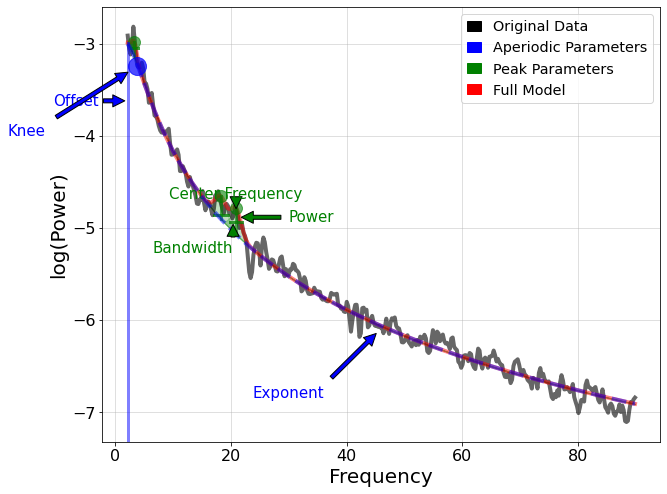

In [82]:
plot_annotated_model(fm)

In [79]:
cln_spectrum_db = avg_wo_aperiodic +  np.mean(aperiodic_comp,0)

In [80]:
cln_spectrum = np.power(10, cln_spectrum_db)

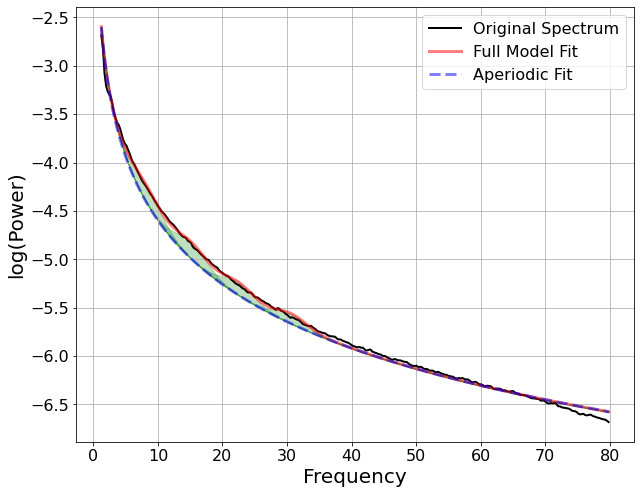

In [648]:
# Initialize a FOOOF model object with defined settings
fm = FOOOF(peak_width_limits=[1.0, 5.0], max_n_peaks=5, min_peak_height=0.1,
           peak_threshold=2, aperiodic_mode='fixed')

freq_range = [1, 80]

# Model the power spectrum with FOOOF, and print out a report
fm.fit(fg.freqs, cln_spectrum, freq_range)
fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})

For demonstrative purposes, the fully annotated FOOOF model parameters

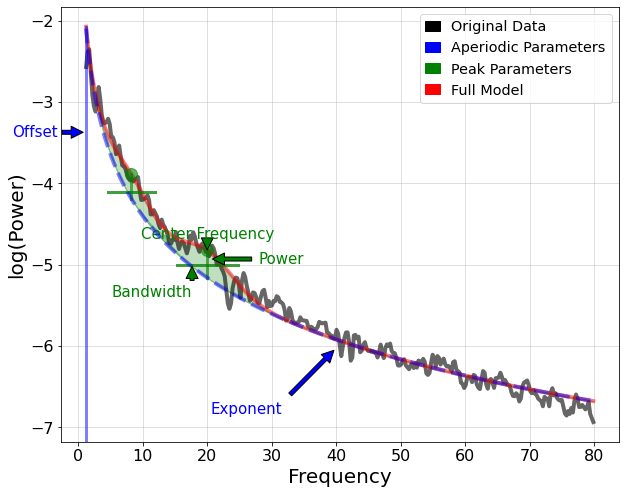

In [1037]:
# Plot an annotated version of the power spectrum model
plot_annotated_model(fm)